In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import chi2_contingency
from itertools import combinations

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [2]:
#Read data

train_df = pd.read_csv('data/train.csv')
train_df_initial = pd.read_csv('data/train.csv')
len(train_df.columns)

81

In [3]:
#Select duplicate data

train_df_initial.drop_duplicates(inplace=True)

train_df_initial.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
#Count NaN values per column and check variables

nan_pro_column = train_df_initial.isna().sum()

num_columns_with_NaN = nan_pro_column[nan_pro_column > 0].sort_values(ascending=False)

num_columns_with_NaN
#missing_values_columns =['LotFrontage',  'MasVnrArea', 'GarageCond',  'GarageType', 'GarageYrBlt', 'GarageFinish', 'BsmtFinType1', 'BsmtFinType2'] -> eliminate?


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [5]:
#For the 'Electrical' feature, drop the only row that has a NaN
train_df_initial.dropna(subset=['Electrical'], inplace=True)

In [6]:
# In columns with NaN values, replace NaN with the string 'NA'
train_df_initial.fillna({'Alley': 'NA'}, inplace=True)
train_df_initial.fillna({'MasVnrType': 'NA'}, inplace=True)
train_df_initial.fillna({'BsmtQual': 'NA'}, inplace=True)
train_df_initial.fillna({'BsmtCond': 'NA'}, inplace=True)
train_df_initial.fillna({'BsmtExposure': 'NA'}, inplace=True)
train_df_initial.fillna({'FirePlaceQu': 'NA'}, inplace=True)
train_df_initial.fillna({'GarageQual': 'NA'}, inplace=True)
train_df_initial.fillna({'GarageCond': 'NA'}, inplace=True)
train_df_initial.fillna({'Fence': 'NA'}, inplace=True)
train_df_initial.fillna({'MiscFeature': 'NA'}, inplace=True)

In [7]:
# Count NaN values per column and check variables. Remove rows with finite values in the columns

nan_pro_column_2 = train_df_initial.isna().sum()

num_columns_with_NaN_2 = nan_pro_column_2[nan_pro_column_2 > 0].sort_values(ascending=False)

missing_values_columns = num_columns_with_NaN_2.index.tolist()

In [8]:
# Drop columns with missing values
train_df_initial.drop(missing_values_columns, axis=1, inplace=True)

len(train_df_initial.columns)

72

In [9]:
# Processing numerical columns

# Select numerical columns to get an initial overview for a linear regression
numerical_cols = train_df_initial.select_dtypes(include=['int64', 'float64']).columns

train_df_initial_num = train_df_initial[numerical_cols]

In [10]:
# Check for NaN values in numerical columns
train_df_initial_num.info(True)

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1459 non-null   int64
 1   MSSubClass     1459 non-null   int64
 2   LotArea        1459 non-null   int64
 3   OverallQual    1459 non-null   int64
 4   OverallCond    1459 non-null   int64
 5   YearBuilt      1459 non-null   int64
 6   YearRemodAdd   1459 non-null   int64
 7   BsmtFinSF1     1459 non-null   int64
 8   BsmtFinSF2     1459 non-null   int64
 9   BsmtUnfSF      1459 non-null   int64
 10  TotalBsmtSF    1459 non-null   int64
 11  1stFlrSF       1459 non-null   int64
 12  2ndFlrSF       1459 non-null   int64
 13  LowQualFinSF   1459 non-null   int64
 14  GrLivArea      1459 non-null   int64
 15  BsmtFullBath   1459 non-null   int64
 16  BsmtHalfBath   1459 non-null   int64
 17  FullBath       1459 non-null   int64
 18  HalfBath       1459 non-null   int64
 19  BedroomAbvG

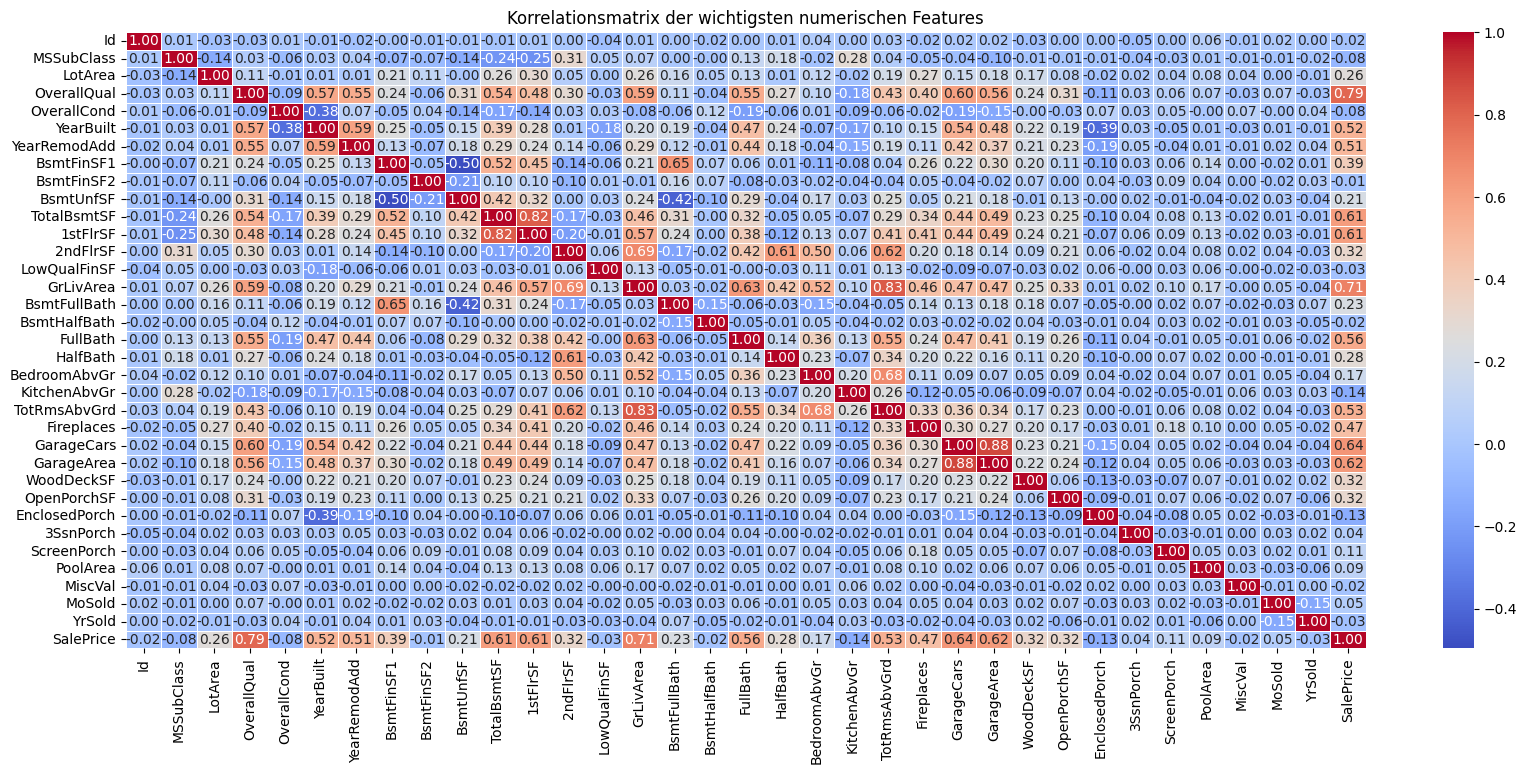

In [11]:
# 1. Numerical feature selection based on the correlation matrix

# Compute the correlation matrix for numerical columns
corr_matrix = train_df_initial[numerical_cols].corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der wichtigsten numerischen Features')
plt.show()

In [12]:
# Select the most important variables from a linear perspective

main_var_maske = corr_matrix['SalePrice'] > 0.45

main_corr_matrix = corr_matrix[main_var_maske]

type(main_corr_matrix.iloc[:, 0]) #Serie

main_columns = main_corr_matrix.iloc[:, 0].index

main_corr_matrix[main_columns]# None of these belong to columns with many missing values

main_columns


Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

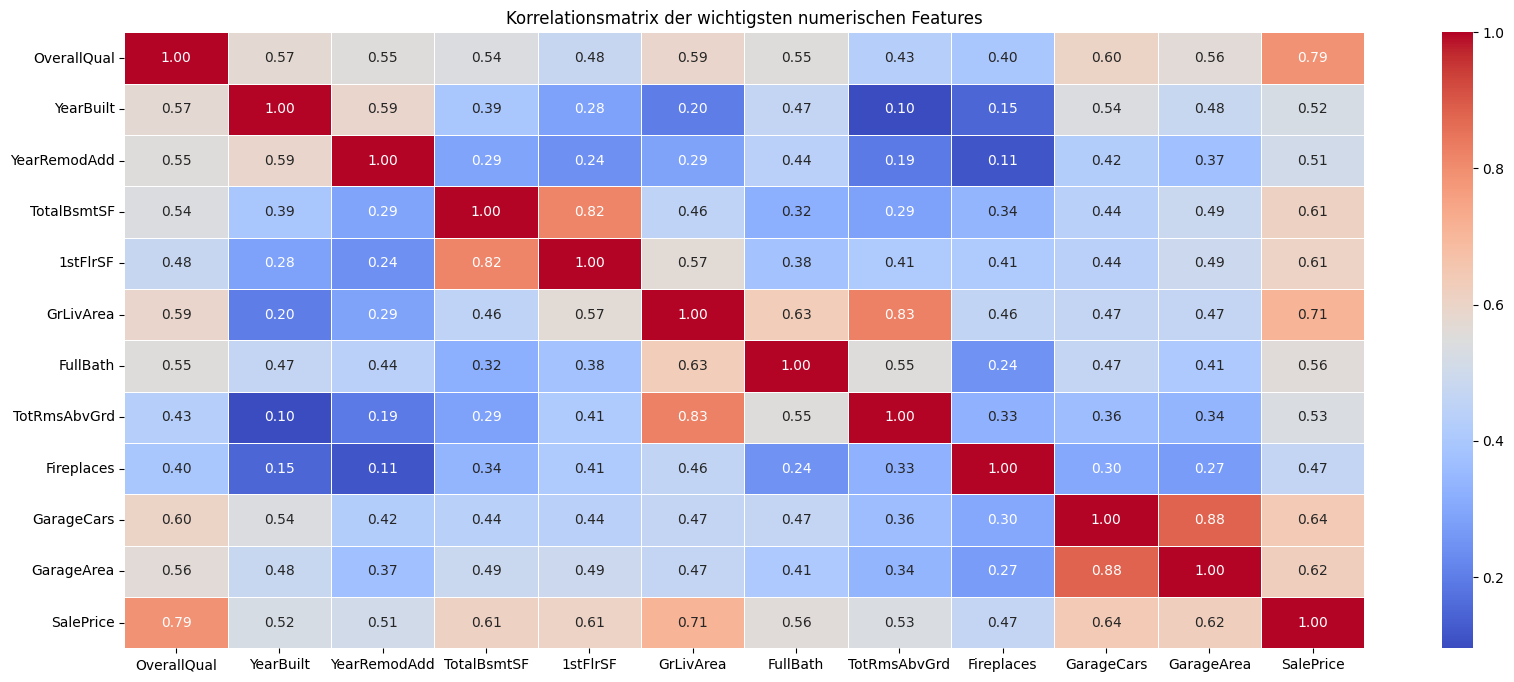

In [13]:
# Visualization of the most important variables from a linear perspective

corr_matrix_clean = main_corr_matrix[main_columns]

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix_clean, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix der wichtigsten numerischen Features')
plt.show()

In [14]:
# Select variables that are NOT multicollinear

vif_data = pd.DataFrame()

X_vif = main_corr_matrix[main_columns]

vif_data["feature"] = X_vif.columns

vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
print(vif_data)

train_df_main = train_df_initial[main_columns]

         feature         VIF
0    OverallQual   64.182623
1      YearBuilt   24.883085
2   YearRemodAdd   11.071210
3    TotalBsmtSF   76.523233
4       1stFlrSF   81.865971
5      GrLivArea  193.285865
6       FullBath   24.602144
7   TotRmsAbvGrd   62.187925
8     Fireplaces    6.410674
9     GarageCars  189.782703
10    GarageArea  167.595322
11     SalePrice  127.477324


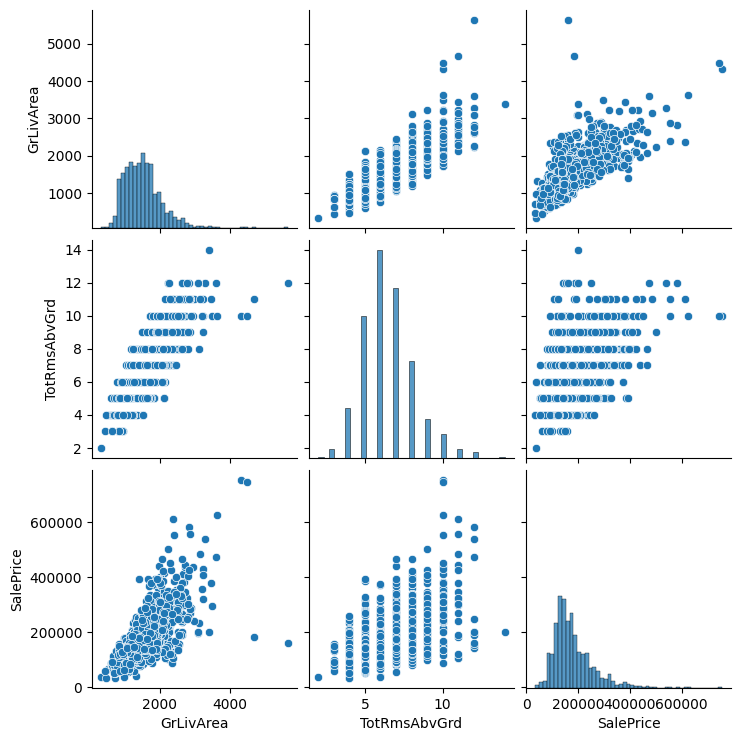

In [15]:
# Check features with the highest VIF that represent similar measurements

# 'GrLivArea', 'TotRmsAbvGrd' -> above grade (ground) living area square feet / total rooms above ground
# 'TotalBsmtSF', '1stFlrSF' -> basement area / first floor area
# 'GarageCars', 'GarageArea' -> number of garage cars / garage area in square feet

sns.pairplot(train_df_main, vars=['GrLivArea', 'TotRmsAbvGrd', 'SalePrice'])
plt.show()

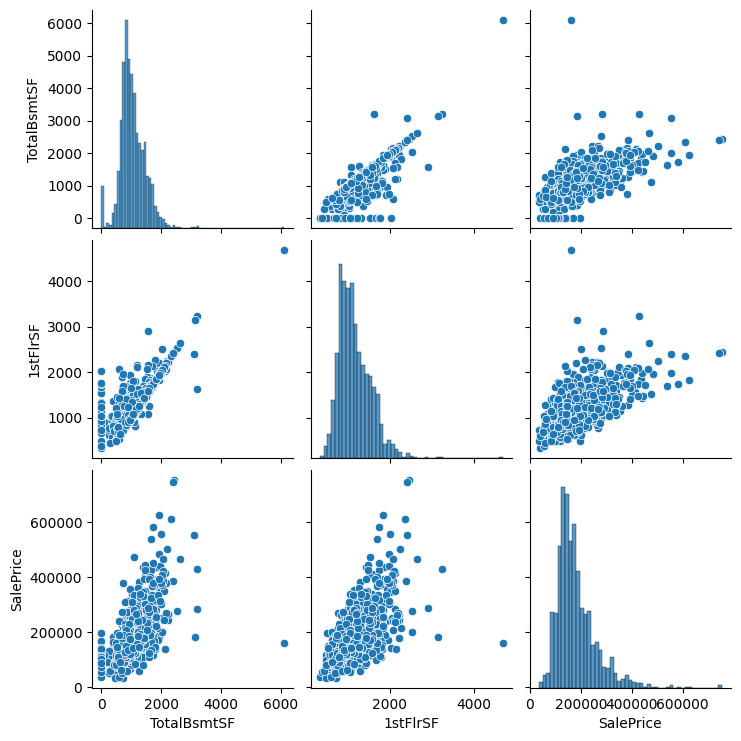

In [16]:
sns.pairplot(train_df_main, vars=['TotalBsmtSF', '1stFlrSF', 'SalePrice'])
plt.show()

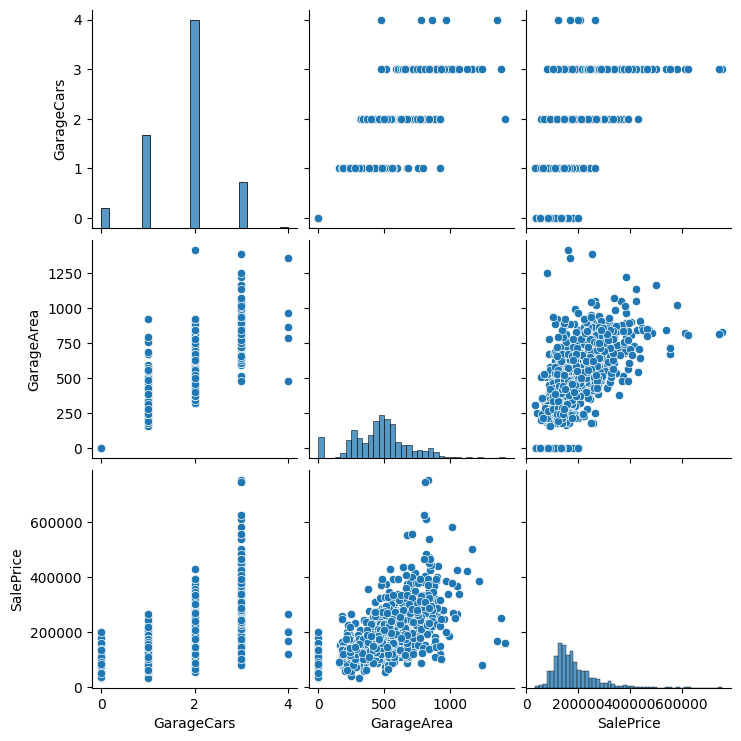

In [17]:
sns.pairplot(train_df_main, vars=['GarageCars','GarageArea', 'SalePrice'])
plt.show()

In [18]:
# Select numerical variables that are relevant for a linear regression model
train_df_main = train_df_initial[main_columns].drop(['1stFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis=1)

# clean_main_columns = train_df_main.columns

# clean_main_columns

train_df_main

# Export the most relevant numerical features

train_df_main.to_csv('data/train_cleaned_num.csv', index=False)

In [19]:
# Processing categorical features

# Select all categorical columns

categorical_cols = train_df_initial.select_dtypes(include=['object']).columns

train_df_initial[categorical_cols]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Electrical,KitchenQual,Functional,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,SBrkr,Gd,Typ,TA,TA,Y,NA,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,SBrkr,TA,Typ,TA,TA,Y,NA,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,SBrkr,Gd,Typ,TA,TA,Y,NA,NA,WD,Normal
3,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,SBrkr,Gd,Typ,TA,TA,Y,NA,NA,WD,Abnorml
4,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,SBrkr,Gd,Typ,TA,TA,Y,NA,NA,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,SBrkr,TA,Typ,TA,TA,Y,NA,NA,WD,Normal
1456,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,SBrkr,TA,Min1,TA,TA,Y,MnPrv,NA,WD,Normal
1457,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,SBrkr,Gd,Typ,TA,TA,Y,GdPrv,Shed,WD,Normal
1458,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,FuseA,Gd,Typ,TA,TA,Y,NA,NA,WD,Normal


In [20]:
# Get information about the data and select columns with too many NaN (missing values)

missing_values_columns_cat = []

for col in train_df_initial[categorical_cols].columns:
    if train_df_initial[col].isnull().sum() > 0:
        missing_values_columns_cat.append(col)
        
missing_values_columns_cat 

train_df_initial[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1459 non-null   object
 1   Street         1459 non-null   object
 2   Alley          1459 non-null   object
 3   LotShape       1459 non-null   object
 4   LandContour    1459 non-null   object
 5   Utilities      1459 non-null   object
 6   LotConfig      1459 non-null   object
 7   LandSlope      1459 non-null   object
 8   Neighborhood   1459 non-null   object
 9   Condition1     1459 non-null   object
 10  Condition2     1459 non-null   object
 11  BldgType       1459 non-null   object
 12  HouseStyle     1459 non-null   object
 13  RoofStyle      1459 non-null   object
 14  RoofMatl       1459 non-null   object
 15  Exterior1st    1459 non-null   object
 16  Exterior2nd    1459 non-null   object
 17  MasVnrType     1459 non-null   object
 18  ExterQual      1459 non-null   ob

In [21]:
# Drop columns with many missing values and add the target column

train_df_cat_rel = train_df_initial[categorical_cols].drop(missing_values_columns_cat, axis=1)

train_df_cat_rel['SalePrice'] = train_df_initial['SalePrice']

train_df_cat_rel_no_targ = train_df_cat_rel.drop('SalePrice', axis=1).reset_index(drop=True)

In [22]:
# 1. ANOVA test to select categorical columns that might be relevant for regression
# For each category, a linear regression model is created

rel_cat = []

for feature in train_df_cat_rel_no_targ.columns:
    model = ols(f'SalePrice ~ C({feature})', data=train_df_cat_rel).fit() #Ordinary Least Squares-Model
    table = sm.stats.anova_lm(model, typ=2)
    if table['PR(>F)'][0] < 0.05:
        rel_cat.append(feature)

rel_cat

C:\Users\Ella\AppData\Local\Temp\ipykernel_39740\2425336709.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if table['PR(>F)'][0] < 0.05:
C:\Users\Ella\AppData\Local\Temp\ipykernel_39740\2425336709.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if table['PR(>F)'][0] < 0.05:
C:\Users\Ella\AppData\Local\Temp\ipykernel_39740\2425336709.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if table['PR(>F)'][0] < 0.05:
C:\Users\E

['MSZoning',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [23]:
# Chi-square test to detect multicollinearity / associations among categorical variables and further filter variables
# https://www.geeksforgeeks.org/python/python-pearsons-chi-square-test/

results = []

for var1, var2 in combinations(train_df_cat_rel_no_targ.columns, 2):
    contingency_table = pd.crosstab(train_df_cat_rel_no_targ[var1], train_df_cat_rel_no_targ[var2])
    
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
            try:
                chi2, p, dof, expected = chi2_contingency(contingency_table)
                results.append({
                    'Variable 1': var1,
                    'Variable 2': var2,
                    'Chi2': chi2,
                    'p-value': p,
                    'DoF': dof
                })
            except ValueError as e:
                print(f"Skipped pair ({var1}, {var2}): {e}")
            
results_df = pd.DataFrame(results)

results_df

,Variable 1,Variable 2,Chi2,p-value,DoF
0,MSZoning,Street,94.674494,1.336524e-19,4
1,MSZoning,Alley,448.538853,7.603383e-92,8
2,MSZoning,LotShape,113.446633,1.242510e-18,12
3,MSZoning,LandContour,57.541479,6.309819e-08,12
4,MSZoning,Utilities,0.268880,9.917335e-01,4
...,...,...,...,...,...
661,Fence,SaleType,50.600195,1.949698e-02,32
662,Fence,SaleCondition,49.977449,2.231288e-04,20
663,MiscFeature,SaleType,19.913985,9.527367e-01,32
664,MiscFeature,SaleCondition,7.873514,9.926720e-01,20


In [24]:
# p-value < 0.05 -> statistically indicates a correlation/association between the categories according to the Chi-square test

corr_values = results_df[results_df['p-value'] < 0.05][['Variable 1', 'Variable 2']]

to_exclude = set()

for _, row in corr_values.iterrows():
    to_exclude.add(row['Variable 2'])

df_uncorrelated = train_df_cat_rel_no_targ.drop(columns=list(to_exclude))

df_uncorrelated

,MSZoning,Utilities
0,RL,AllPub
1,RL,AllPub
2,RL,AllPub
3,RL,AllPub
4,RL,AllPub
...,...,...
1454,RL,AllPub
1455,RL,AllPub
1456,RL,AllPub
1457,RL,AllPub


In [25]:
cat_anova_train_df_encoded = pd.get_dummies(df_uncorrelated, columns=df_uncorrelated.columns, drop_first=True)

cat_anova_train_df_encoded

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Utilities_NoSeWa
0,False,False,True,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False
...,...,...,...,...,...
1454,False,False,True,False,False
1455,False,False,True,False,False
1456,False,False,True,False,False
1457,False,False,True,False,False


In [26]:
# Complete DataFrame with numerical and categorical columns, categorical features filtered by ANOVA / Chi-square

whole_anova_train_df = pd.concat([train_df_main, cat_anova_train_df_encoded], axis=1)

In [27]:
# Check for NaN (missing) values

whole_anova_train_df[whole_anova_train_df.isna().any(axis=1)]

whole_anova_train_df = whole_anova_train_df.dropna()

whole_anova_train_df[whole_anova_train_df.isna().any(axis=1)]

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,Fireplaces,GarageArea,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Utilities_NoSeWa


In [28]:
# Export to CSV files
whole_anova_train_df.to_csv('data/train_cleaned_anova.csv', index=False)


In [29]:
# 2A Presumed most important categorical variables based on analysis and domain knowledge
categorical_rel_features = ['HouseStyle', 'Condition1', 'Neighborhood', 'MSZoning', 'SaleCondition']

cat_train_df = train_df_initial[categorical_rel_features]

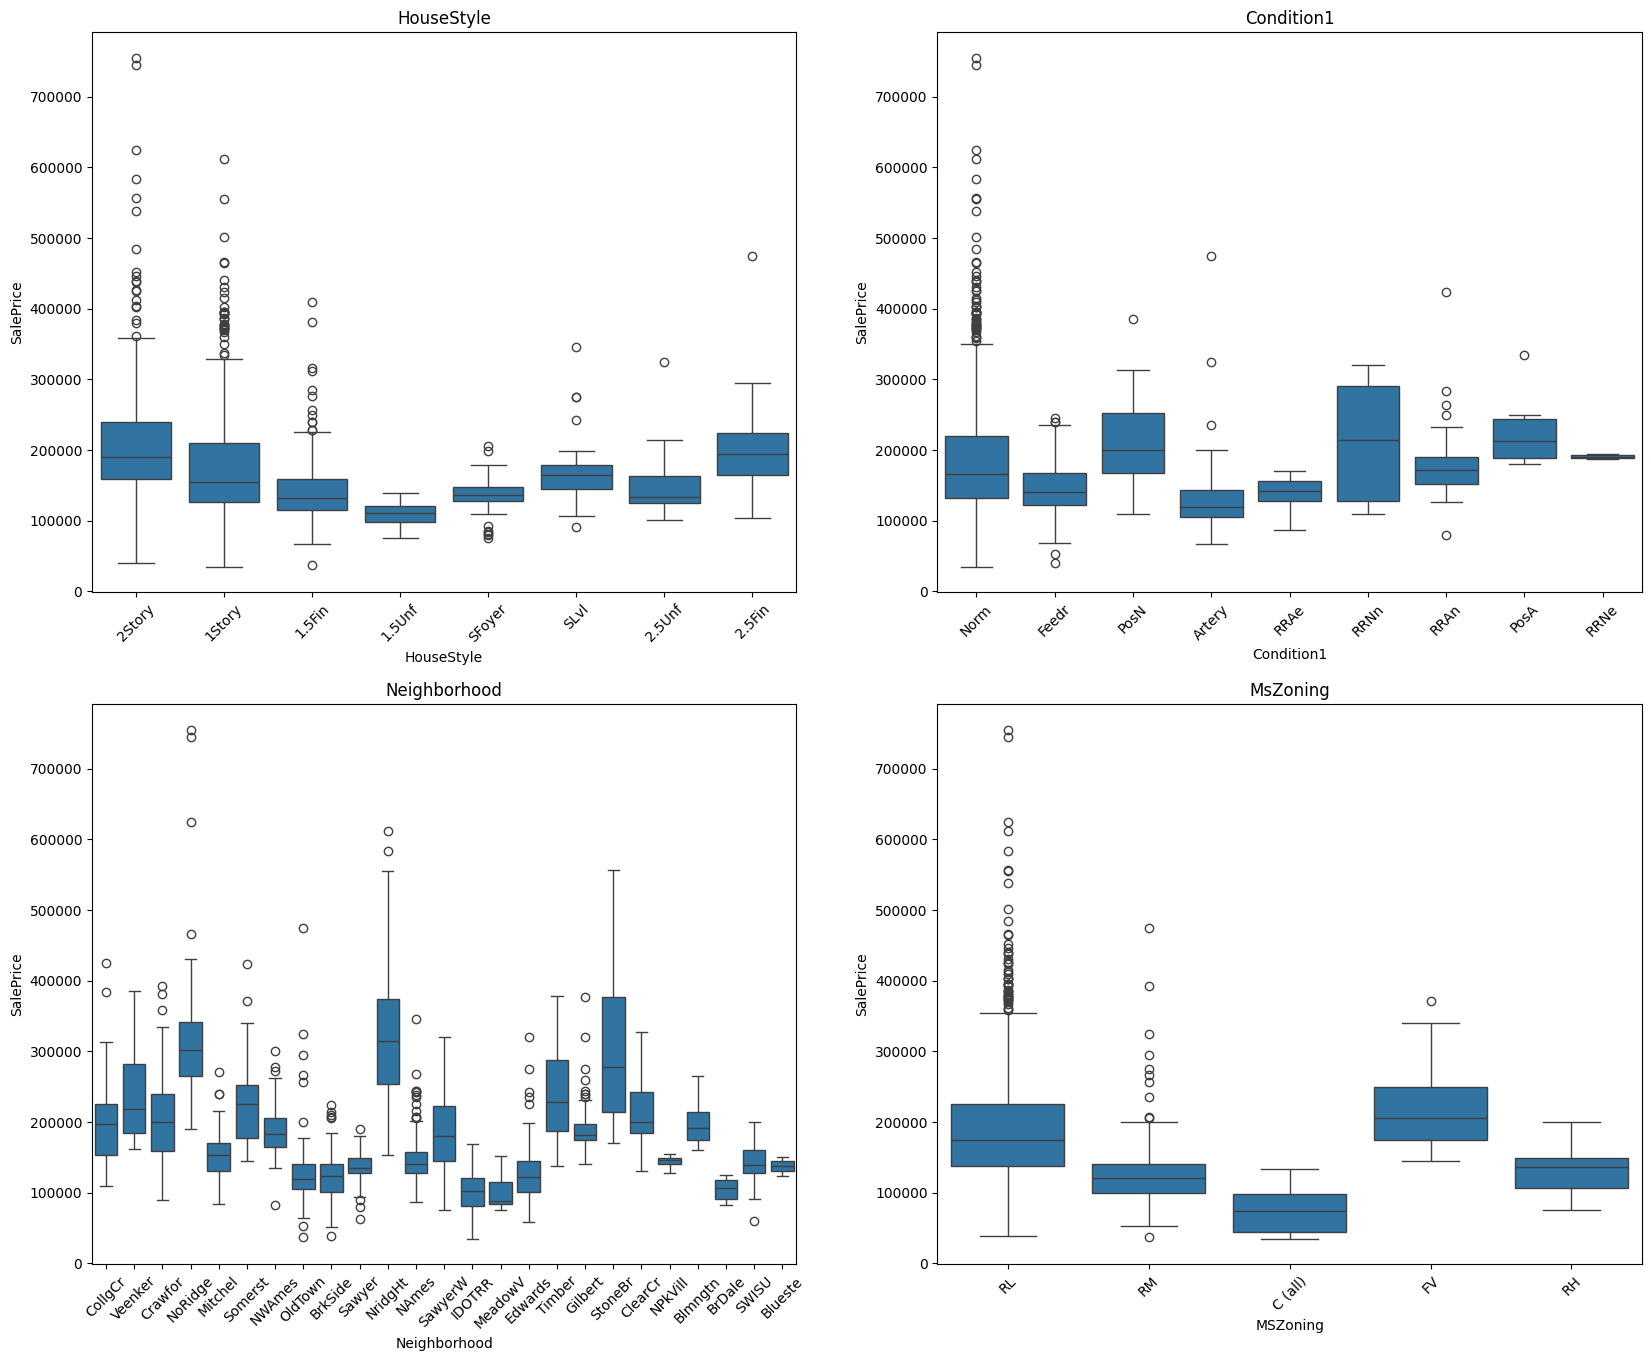

In [30]:
# Analyze presumed important categorical variables using boxplots

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

sns.boxplot(x='HouseStyle', y='SalePrice', ax=axes[0, 0], data=train_df_initial)
axes[0, 0].set_title('HouseStyle')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Condition1', y='SalePrice', data=train_df_initial, ax=axes[0, 1])
axes[0, 1].set_title('Condition1')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.boxplot(x='Neighborhood', y='SalePrice', ax=axes[1, 0], data=train_df_initial)
axes[1, 0].set_title('Neighborhood')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(x='MSZoning', y='SalePrice', data=train_df_initial, ax=axes[1, 1])
axes[1, 1].set_title('MsZoning')
axes[1, 1].tick_params(axis='x', rotation=45)

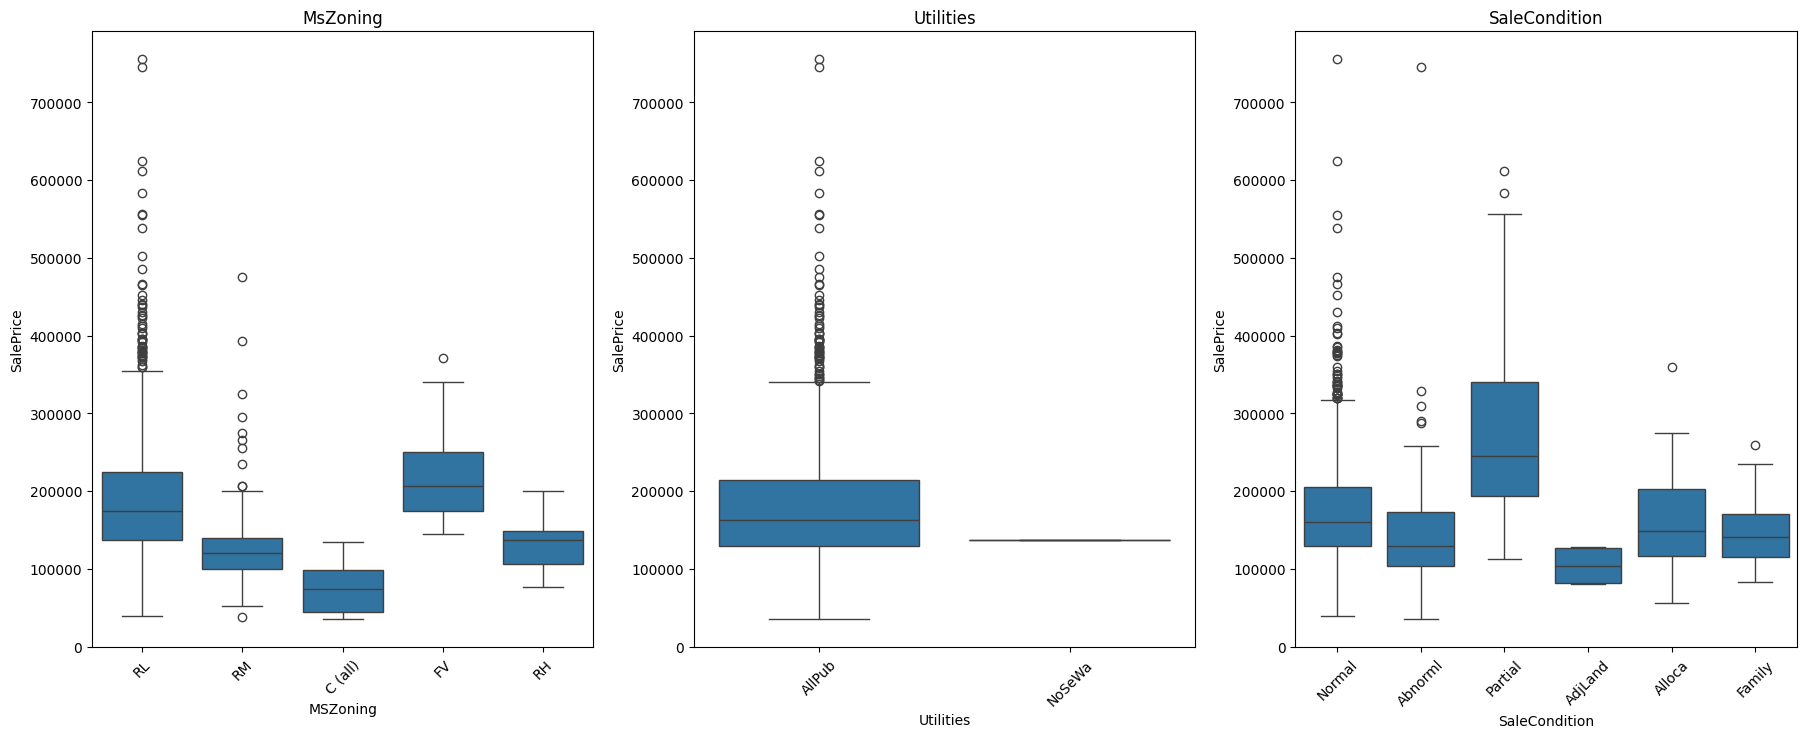

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

sns.boxplot(x='MSZoning', y='SalePrice', data=train_df_initial, ax=axes[0])
axes[0].set_title('MsZoning')
axes[0].tick_params(axis='x', rotation=45)


sns.boxplot(x='Utilities', y='SalePrice', data=train_df_initial, ax=axes[1])
axes[1].set_title('Utilities')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='SaleCondition', y='SalePrice', data=train_df_initial, ax=axes[2])
axes[2].set_title('SaleCondition')
axes[2].tick_params(axis='x', rotation=45)

In [32]:
# Ordinal vs Nominal features based on analysis and domain knowledge

ordinal_cols = ['HouseStyle']
nominal_cols = ['Condition1', 'Neighborhood', 'MSZoning', 'SaleCondition']

In [33]:
# Convert nominal categorical variables to numeric

ohe = OneHotEncoder(drop='first', sparse_output=False)
cat_train_nom_encoded = ohe.fit_transform(cat_train_df[nominal_cols])

col_names = ohe.get_feature_names_out(nominal_cols)

df_train_nom_encoded = pd.DataFrame(cat_train_nom_encoded, columns=col_names)

In [34]:
# Convert ordinal categorical variables to numeric

ord_list = train_df_cat_rel['HouseStyle'].unique().tolist()

ord_list_sorted = ['1Story', '1.5Unf', '1.5Fin', '2Story', '2.5Unf', '2.5Fin', 'SFoyer', 'SLvl']

oe = OrdinalEncoder(categories=[ord_list_sorted])
cat_train_ord_encoded = oe.fit_transform(train_df_cat_rel[['HouseStyle']])

df_train_ord_encoded = pd.DataFrame(cat_train_ord_encoded, columns=['HouseStyle_encoded'])

In [35]:

# Complete DataFrame with numerical and categorical columns, categorical features filtered by analysis
whole_back_analysis_train_df = pd.concat([train_df_main, df_train_nom_encoded, df_train_ord_encoded], axis=1)

whole_back_analysis_train_df[whole_back_analysis_train_df.isna().any(axis=1)]


whole_back_analysis_train_df = whole_back_analysis_train_df.dropna()

whole_back_analysis_train_df[whole_back_analysis_train_df.isna().any(axis=1)]


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,Fireplaces,GarageArea,SalePrice,Condition1_Feedr,...,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseStyle_encoded


In [36]:
whole_back_analysis_train_df.to_csv('data/train_cleaned_analyse.csv', index=False)

In [37]:
# 2B Encode categorical variables using dummy/one-hot encoding

cat_analyse_train_df_dummy = pd.get_dummies(cat_train_df, columns=cat_train_df.columns, drop_first=True)

cat_analyse_train_df_dummy

,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Condition1_Feedr,Condition1_Norm,Condition1_PosA,...,Neighborhood_Veenker,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,False,True,False,False,False,False,False,True,False,False,...,True,False,False,True,False,False,False,False,True,False
2,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1456,False,True,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1457,False,False,False,False,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1458,False,True,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False


In [38]:
# Complete dataset with numerical and encoded categorical variables after analysis

whole_analysis_dummy_train_df = pd.concat([train_df_main, cat_analyse_train_df_dummy], axis=1)

whole_analysis_dummy_train_df[whole_analysis_dummy_train_df.isna().any(axis=1)]

whole_analysis_dummy_train_df = whole_analysis_dummy_train_df.dropna()

whole_analysis_dummy_train_df[whole_analysis_dummy_train_df.isna().any(axis=1)]

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FullBath,Fireplaces,GarageArea,SalePrice,HouseStyle_1.5Unf,...,Neighborhood_Veenker,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


In [39]:
whole_analysis_dummy_train_df.to_csv('data/train_cleaned_dummy_analyse.csv', index=False)

In [40]:
whole_analysis_df = pd.concat([train_df_main, cat_train_df], axis=1)

whole_analysis_df.to_csv('data/whole_analysis_df.csv', index=False)

## BEARBEITEN DER TEST DATEN ##

In [41]:
# Read test data
test_df_initial = pd.read_csv('data/test.csv')

In [42]:
# First insights

test_df_initial.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [43]:
test_df_initial.drop_duplicates(inplace=True)

test_df_initial.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [44]:
test_df_initial.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [45]:
nan_pro_column = test_df_initial.isna().sum()

num_columns_with_NaN = nan_pro_column[nan_pro_column > 0].sort_values(ascending=False)

num_columns_with_NaN

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageQual        78
GarageCond        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64

In [46]:
# In columns where NaN represents a value, replace NaN with 'NA' string
test_df_initial.fillna({'Alley': 'NA'}, inplace=True)
test_df_initial.fillna({'MasVnrType': 'NA'}, inplace=True)
test_df_initial.fillna({'BsmtQual': 'NA'}, inplace=True)
test_df_initial.fillna({'BsmtCond': 'NA'}, inplace=True)
test_df_initial.fillna({'BsmtExposure': 'NA'}, inplace=True)
test_df_initial.fillna({'FirePlaceQu': 'NA'}, inplace=True)
test_df_initial.fillna({'GarageQual': 'NA'}, inplace=True)
test_df_initial.fillna({'GarageQual': 'NA'}, inplace=True)
test_df_initial.fillna({'Fence': 'NA'}, inplace=True)
test_df_initial.fillna({'MiscFeature': 'NA'}, inplace=True)

In [47]:
# After data cleaning, keep relevant columns and check for NaN values

# Numerical

numerical_rel_features  = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea',
       'FullBath', 'Fireplaces', 'GarageArea'] #train_df_main.columns ohne SalePrice

test_df_num = test_df_initial[numerical_rel_features]

test_df_num.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   YearBuilt     1459 non-null   int64  
 2   YearRemodAdd  1459 non-null   int64  
 3   TotalBsmtSF   1458 non-null   float64
 4   GrLivArea     1459 non-null   int64  
 5   FullBath      1459 non-null   int64  
 6   Fireplaces    1459 non-null   int64  
 7   GarageArea    1458 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 91.3 KB


In [48]:
# Only two missing values (numerical) will be filled with the mean

test_df_num['TotalBsmtSF'] = test_df_num['TotalBsmtSF'].fillna(test_df_num['TotalBsmtSF'].mean())
test_df_num['GarageArea'] = test_df_num['GarageArea'].fillna(test_df_num['GarageArea'].mean())

test_df_num.info(True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   YearBuilt     1459 non-null   int64  
 2   YearRemodAdd  1459 non-null   int64  
 3   TotalBsmtSF   1459 non-null   float64
 4   GrLivArea     1459 non-null   int64  
 5   FullBath      1459 non-null   int64  
 6   Fireplaces    1459 non-null   int64  
 7   GarageArea    1459 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 91.3 KB


C:\Users\Ella\AppData\Local\Temp\ipykernel_39740\3683264080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_num['TotalBsmtSF'] = test_df_num['TotalBsmtSF'].fillna(test_df_num['TotalBsmtSF'].mean())
C:\Users\Ella\AppData\Local\Temp\ipykernel_39740\3683264080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_num['GarageArea'] = test_df_num['GarageArea'].fillna(test_df_num['GarageArea'].mean())


In [49]:
# Add categorical variables to linear regression based on domain knowledge

cat_test_df_encoded = pd.get_dummies(test_df_initial[categorical_rel_features], columns=categorical_rel_features, drop_first=True)

cat_test_df_encoded

,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,...,Neighborhood_Veenker,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,False,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
4,False,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
1455,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
1456,False,True,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1457,False,False,False,False,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False


In [50]:
# Complete DataFrame with numerical and categorical columns

whole_test_df = pd.concat([test_df_num, cat_test_df_encoded], axis=1)

whole_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OverallQual            1459 non-null   int64  
 1   YearBuilt              1459 non-null   int64  
 2   YearRemodAdd           1459 non-null   int64  
 3   TotalBsmtSF            1459 non-null   float64
 4   GrLivArea              1459 non-null   int64  
 5   FullBath               1459 non-null   int64  
 6   Fireplaces             1459 non-null   int64  
 7   GarageArea             1459 non-null   float64
 8   HouseStyle_1.5Unf      1459 non-null   bool   
 9   HouseStyle_1Story      1459 non-null   bool   
 10  HouseStyle_2.5Unf      1459 non-null   bool   
 11  HouseStyle_2Story      1459 non-null   bool   
 12  HouseStyle_SFoyer      1459 non-null   bool   
 13  HouseStyle_SLvl        1459 non-null   bool   
 14  Condition1_Feedr       1459 non-null   bool   
 15  Cond

In [51]:
missing_columns = []

for col in whole_back_analysis_train_df.columns:
    if col not in whole_test_df.columns:
        missing_columns.append(col)
        
missing_columns

len(whole_back_analysis_train_df.columns) == len(whole_test_df.columns) + 1


False

In [52]:
# Export the cleaned test data as CSV

whole_test_df.to_csv('data/test_cleaned_analyse.csv', index=False)